Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:


In [67]:
NAME = "Piotr Durniat"

In [80]:
# import os
# os.chdir("/root")

---


# 2. Model TNC

Przedstawimy teraz zasadę działania modelu TNC, zaimplementujemy jego najistotniejsze elementy oraz dokonamy ewaluacji modelu.


## 2.1. Idea modelu TNC

Dla ciągu czasowego $X \in \mathbb{R}^{D \times T}$ możemy określić okno przesuwne $X_{[t - \frac{\delta}{2}, t + \frac{\delta}{2}]}$ o długości $\delta$ wycentrowane wokół chwili $t$, które zawiera pomiary wszystkich cech w przedziale czasu $[t - \frac{\delta}{2}, t + \frac{\delta}{2}]$. Dla ułatwienia zapisu okno to będzie oznaczane jako $W_t$.

Celem metody uczenia reprezentacji będzie uzyskanie wektorowej reprezentacji dowolnego okna $W_t$.


### Temporalne sąsiedztwo

Dla okna $W_t$ zdefiniujmy jego temporalne sąsiedztwo $N_t$ jako zbiór wszystkich okien wycentrowanych w $t^*$, gdzie wartość ta jest próbkowana z rozkładu normalnego $t^* \sim \mathcal{N}(t, \eta \cdot \delta)$. Parametr $\eta$ definiuje szerokość / zakres sąsiedztwa temporalnego.

Wybór parametru $\eta$ może być oparty o wiedzę ekspercką, jednak w publikacji autorzy zaproponowali zastosowanie testu statystycznego **Augmented Dickey-Fuller (ADF)**, który będzie sprawdzać stacjonarność rozkładu próbek w sąsiedztwie temporalnym. Algorytm wyboru parametru zakłada, że rozpoczynamy od niewielkiej wartości, po czym iteracyjnie zwiększamy parametr $\eta$, powodując poszerzenie się temporalnego sąsiedztwa. Zwiększanie wartości następuje do momentu aż test statystyczny nie będzie w stanie odrzucić hipotezy zerowej.


### "Uczenie kontrastowe"

Okna w sąsiedztwie temporalnym możemy uznać jako podobne do obecnie rozważanego okna ciągu czasowego. Pozostaje zatem pytanie jak uzyskać przykłady negatywne, tak abyśmy mogli zastosować koncepcję uczenia kontrastowego.

Moglibyśmy założyć, że wszystkie próbki (okna) poza temporalnym sąsiedztwem są przykładami negatywnymi. Może się jednak tak zdarzyć, że nawet bardzo odległe okno, jest w istocie podobne do obecnego (ma taką samą dynamikę zmian / pochodzi z tego samego rozkładu). W takiej sytuacji uczenie modelu nie byłoby efektywne. Autorzy proponują użycie podejścia **Positive-Unlabeled (PU) learning**, w którym mamy próbki bazowe, próbki pozytywne i próbki nieoznaczone. W naszym przykładzie próbkami nieoznaczonymi będą próbki spoza sąsiedztwa temporalnego.

Do próbek nieoznaczonych są przypisywane wagi $w$ (tutaj: hiperparametr metody), a każda próbka nieoznaczona jest traktowana jako połączenie próbki pozytywnej z wagą $w$ oraz próbki negatywnej z wagą $1 - w$. Zobaczymy to dalej w funkcji kosztu.


### Koder i dyskryminator

Model TNC będziemy uczyć za pomocą funkcji kosztu, która pozwala odróżniać reprezentacje próbek z tego samego sąsiedztwa temporalnego od próbek spoza sąsiedztwa.

Pierwszym elementem modelu TNC jest **koder** $\text{Enc}(W_t)$, które przekształca okno $W_t \in \mathbb{R}^{D \times \delta}$ w wektor reprezentacji $Z_t \in \mathbb{R}^M$.

Drugim elementem jest **dyskryminator** $\mathcal{D}(Z_t, Z)$ pozwalający aproksymować prawdopodobieństwo tego, że $Z$ jest reprezentacją okna w sąsiedztwie $N_t$. Innymi słowy, dla dwóch wektorów reprezentacji zwraca pradopodobieństwo tego, że te wektory (okna) należą do tego samego sąsiedztwa temporalnego.


Przeanalizujmy rysunek przedstawiający zasadę działania modelu TNC:

![](./assets/tnc.png)


### Funkcja kosztu

W najlepszym przypadku dyskryminator powinien zwracać wartości bliskie 1 dla reprezentacji z tego samego temporalnego sąsiedztwa oraz wartość 0 w przeciwnym przypadku. Funkcja kosztu jest zdefiniowana następująco:

$$\mathcal{L} = -\mathbb{E}_{W_t\sim X}\left[ \mathbb{E}_{W_l \sim N_t}[\log \mathcal{D}(Z_t,Z_l)] +\mathbb{E}_{W_k \sim \bar{N}_t}[(1-w_t)\times \log(1 - \mathcal{D}(Z_t, Z_k)) + w_t\times \log\mathcal{D}(Z_t, Z_k)] \right]$$


## 2.2. Implementacja kodera

Ze względu na sekwencyjny charakter próbek w oknie, jako model kodera użyjemy dwukierunkowej sieci rekurencyjnego typu GRU, która na wyjściu cechy przekształci dodatkową warstwą liniową. Sieć rekurencyjna dostarcza nam stany ukryte w formie wektorów dla każdego punktu wejściowego w sekwencji, więc w celu otrzymania jednego wektora podsumowującego całą sekwencję należy dokonać odpowiedniej agragacji. W niniejszym koderze rozwarzymy dwie metody agregacji sekwencji stanów ukrytych:

- wybór ostatniego stanu ukrytego
- agregacja stanów ukrytych z wykorzystaniem mechanizmu uwagi (ang. _attention_)


## Zadanie 2.1 (1.5 pkt)

Zaimplementuj dwie klasy dla dwóch niżej zdefiniowanych stanów ukrytych:

1. `LastHiddenAggreagation` (0.5 pkt) - metoda `forward(...)` zwraca ostatni stan ukryty z sekwencji
2. `AttentionAggregation` (1 pkt):
   - aplikuje [_scaled dot product attention_](https://arxiv.org/abs/1706.03762) oraz oblicza średnią z otrzymanych wektorów
   - podpowiedź: możesz wykorzystać `torch.nn.MultiHeadAttention` z parametrem `num_heads=1`, ale **należy mieć zrozumienie i intuicje, jak działa mechanizm uwagi i jak może pomagać w agregacji**


In [111]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F


class LastHiddenAggregation(nn.Module):
    def forward(self, rnn_output: Tensor) -> Tensor:
        """Aggregates information from sequence of vectors by taking last state.
        rnn_output: Tensor with dimensions [sequence_length, batch_size, hidden_dim]
        returns: Tensor with dimensions [batch_size, hidden_dim]
        """
        # TU WPISZ KOD
        return rnn_output[-1, :, :]


class AttentionAggregation(nn.Module):
    multihead_attn: nn.MultiheadAttention

    def __init__(self, hidden_dim: int):
        super().__init__()
        # TU WPISZ KOD
        self.multihead_attn = nn.MultiheadAttention(hidden_dim, num_heads=1)

    def forward(self, rnn_output: Tensor) -> Tensor:
        """Aggregates information from sequence of vectors with additive attention.
        rnn_output: Tensor with dimensions [sequence_length, batch_size, hidden_dim]
        returns: Tensor with dimensions [batch_size, hidden_dim]
        """
        # TU WPISZ KOD
        attn_output, _ = self.multihead_attn(rnn_output, rnn_output, rnn_output)
        aggregated_hidden = attn_output.mean(dim=0)
        return aggregated_hidden

## Zadanie 2.2 (1.5 pkt)

Zaimplementuj klasę `GRUEncoder` zgodnie z poniższymi wymaganiami:

- w metodzie `__init__()`:
  - utwórz instancję sieci GRU o wymiarze wejściowym `in_dim`, wymiarze ukrytym `hidden_dim`, która posiada jedną warstwę oraz jest dwukierunkowa (ustaw dodatkowo parametr `batch_first=False`)
  - utwórz instancję warstwy liniowej o odpowiednim wymiarze wejściowym oraz wyjściu o wymiarowości `emb_dim`
- w metodzie `_get_initial_hidden()` utwórz wektor zer jako początkowy stan ukryty
- w metodzie `forward()` przetwórz cechy okień podanych na wejściu i wyznacz wektory reprezentacji (używając sieci GRU a następnie warstwy liniowej)


In [110]:
from typing import Literal


class GRUEncoder(nn.Module):
    agg: LastHiddenAggregation | AttentionAggregation
    gru: nn.GRU
    linear: nn.Linear
    hidden_dim: int
    emb_dim: int

    def __init__(
        self,
        agg: Literal["last", "attn"],
        in_dim: int,
        hidden_dim: int,
        emb_dim: int,
    ):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim

        if agg == "last":
            self.agg = LastHiddenAggregation()
        elif agg == "attn":
            self.agg = AttentionAggregation(2 * hidden_dim)
        else:
            raise ValueError(f"Invalid aggregation name")

        # TU WPISZ KOD
        self.gru = nn.GRU(
            input_size=in_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            bidirectional=True,
            batch_first=False,
        )

        self.linear = nn.Linear(2 * hidden_dim, emb_dim)

    def _get_initial_hidden(self, batch_size: int) -> Tensor:
        # TU WPISZ KOD

        device = next(self.parameters()).device
        return torch.zeros((2, batch_size, self.hidden_dim), device=device)

    def forward(self, x: Tensor) -> Tensor:
        x = x.permute(2, 0, 1)
        hidden_state = self._get_initial_hidden(x.size(1))
        output, _ = self.gru(x, hidden_state)
        agg_out = self.agg(output)
        emb = self.linear(agg_out)
        return emb

## 2.3. Implementacja dyskryminatora

Jako dyskryminatora użyjemy prostego dwuwarstwowego perceptrona, tak aby nie ryzykować przeuczeniem tego komponentu.


## Zadanie 2.3 (2 pkt)

Zaimplementuj 2 modele dyskryminatora zgodnie z następującymi wymaganiami:

`DotProductDiscriminator` (1 pkt):

- w metodzie `forward()` zwróc iloczyn skalarny odpowiadających sobie reprezentacji (uprzednio znormalizuj reprezentacje do jednostkowej długości)

`MLPDiscriminator` (1 pkt):

- w metodzie `__init__()` utwórz wielowarstwowy perceptron z następującymi warstwami (`d` to wymiar wejściowy):
  - warstwa liniowa o rozmiarach 2*d na 4*d
  - aktywacja ReLU
  - dropout z prawdp. równym 0.5
  - kolejna warstwa liniowa o rozmiarze 4\*d na 1
- w metodzie `forward()` dokonaj konkatenacji reprezentacji `z` oraz `z_tilde` a następnie przekaż je do perceptrona


In [70]:
class DotProductDiscriminator(nn.Module):
    def forward(self, z: Tensor, z_tilde: Tensor) -> Tensor:
        # TU WPISZ KOD
        z_norm = nn.functional.normalize(z, p=2, dim=-1)
        z_tile_norm = nn.functional.normalize(z_tilde, p=2, dim=-1)
        return (z_norm * z_tile_norm).sum(dim=-1)


class MLPDiscriminator(nn.Module):
    mlp: nn.Sequential

    def __init__(self, input_dim: int):
        super().__init__()
        # TU WPISZ KOD
        self.mlp = nn.Sequential(
            nn.Linear(2 * input_dim, 4 * input_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4 * input_dim, 1),
        )

    def forward(self, z: Tensor, z_tilde: Tensor) -> Tensor:
        # TU WPISZ KOD
        p = torch.cat((z, z_tilde), dim=-1)
        p = self.mlp(p)
        return p.view((-1,))

## 2.4. Implementacja funkcji kosztu

W celu implementacji funkcji kosztu możemy wspomóc się gotową funkcją binarnej entropii krzyżowej, zauważając że problem uczenia dyskryminatora (a zatem całego modelu TNC) sprowadza się do problemu klasyfikacji binarnej.


## Zadanie 2.4 (3 pkt)

Zaimplementuj moduł implementujący funkcję kosztu modelu TNC stosując następujące wskazówki/instrukcje:

- `z_t` to reprezentacje obecnie rozważanych okien, `z_p` to reprezentacje pozytywne, natomiast `z_n` to reprezentacje nieoznaczone
- najpierw wyznacz predykcje dyskryminatora dla pary `(z_t, z_p)` oraz `(z_t, z_n)`
- przygotuj etykiety (zera i jedynki) dla par podobnych oraz różnych
- oblicz funkcję binarnej entropii krzyżowej dla wyników dyskryminatora, pamiętaj, że:
  - parę `(z_t, z_p)` chcemy traktować jako pozytywną (klasa 1)
  - parę `(z_t, z_n)` chcemy traktować jako pozytywną z wagą `w` oraz jako negatywną (klasa 0) z wagą `1 - w`
- zaimplementuj metodę `_compute_accuracy()`, która sprawdzi czy decyzje dyskryminatora są właściwe (pary pozytywne mają prawdp. `> 0.5`, a pary negatwne `< 0.5`; pamiętaj o zastosowaniu funkcji sigmoid!); wyniki uśrednij uzyskując miarę accuracy


In [71]:
from typing import Tuple


class TNCLossFunction(nn.Module):

    def __init__(self, discriminator: Literal["dot", "mlp"], emb_dim: int, w: float):
        super().__init__()

        if discriminator == "dot":
            self.discriminator = DotProductDiscriminator()
        elif discriminator == "mlp":
            self.discriminator = MLPDiscriminator(input_dim=emb_dim)
        else:
            raise ValueError(f"Invalid discriminator: {discriminator}")

        self.bce = torch.nn.BCEWithLogitsLoss()
        self.w = w

    def forward(
        self,
        z_t: Tensor,
        z_p: Tensor,
        z_n: Tensor,
    ) -> Tuple[Tensor, float]:
        d_p = self.discriminator.forward(z_t, z_p)
        d_n = self.discriminator.forward(z_t, z_n)

        # TU WPISZ KOD
        d_p_pos_labels = torch.ones_like(d_p)
        d_p_pos_loss = self.bce(d_p, d_p_pos_labels)
        d_n_pos_labels = torch.ones_like(d_n)
        d_n_pos_loss = self.bce(d_n, d_n_pos_labels)
        d_n_neg_labels = torch.zeros_like(d_n)
        d_n_neg_loss = self.bce(d_n, d_n_neg_labels)

        loss = d_p_pos_loss + self.w * d_n_pos_loss + (1 - self.w) * d_n_neg_loss
        accuracy = self._compute_accuracy(d_p=d_p, d_n=d_n)
        return loss, accuracy

    @staticmethod
    def _compute_accuracy(d_p: Tensor, d_n: Tensor) -> float:
        # TU WPISZ KOD
        d_p = torch.sigmoid(d_p)
        d_n = torch.sigmoid(d_n)

        positives = (d_p > 0.5).sum().item()
        negatives = (d_n < 0.5).sum().item()
        acc = (positives + negatives) / (d_p.shape[0] + d_n.shape[0])

        return acc

## 2.5. Uruchomienie modelu TNC

Poniżej znajduje się kod pozwalający wyuczyć model TNC (implementacja w bibliotece PyTorch-Lightning). Ustawimy domyślny zbiór hiperparametrów i będziemy uczyć model przez 50 epok. Następnie zwizualizujemy otrzymane wektory reprezentacji i zastosujemy je w zadaniu klasyfikacji.


Moduł danych:


In [72]:
import os

import pytorch_lightning as pl
from torch.utils.data import DataLoader

from src.dataset import TNCDataset


class TrainDataModule(pl.LightningDataModule):

    def __init__(
        self,
        mc_sample_size: int,
        window_size: int,
        batch_size: int,
    ):
        super().__init__()

        self.mc_sample_size = mc_sample_size
        self.window_size = window_size
        self.batch_size = batch_size

        self.dataset = torch.load(f="./data/simulated.pt")

    def train_dataloader(self) -> DataLoader:
        return self._dataloader("x_train")

    def val_dataloader(self) -> DataLoader:
        return self._dataloader("x_val", shuffle=False)

    def _dataloader(self, split: str, shuffle: bool = True) -> DataLoader:
        data = TNCDataset(
            x=self.dataset[split],
            mc_sample_size=self.mc_sample_size,
            window_size=self.window_size,
        )
        return DataLoader(
            data,
            batch_size=self.batch_size,
            shuffle=shuffle,
            num_workers=int(os.environ.get("NUM_WORKERS", 0)),
        )

Model TNC:


In [73]:
import numpy as np
from typing import Any


class TNCModel(pl.LightningModule):

    def __init__(self, hparams: dict[str, Any]):
        super().__init__()

        self.save_hyperparameters(hparams)

        self.encoder = GRUEncoder(
            agg=hparams["agg"],
            in_dim=hparams["in_dim"],
            hidden_dim=hparams["hidden_dim"],
            emb_dim=hparams["emb_dim"],
        )
        self._loss_fn = TNCLossFunction(
            discriminator=hparams["discriminator"],
            emb_dim=self.encoder.emb_dim,
            w=self.hparams["w"],
        )

        self.training_step_outputs = []
        self.validation_step_outputs = []

    def forward(self, x: Tensor) -> Tensor:
        return self.encoder(x)

    def training_step(self, batch, batch_idx):
        loss, acc = self._common_step(batch)
        return {"loss": loss, "acc": acc}

    def validation_step(self, batch, batch_idx):
        loss, acc = self._common_step(batch)
        return {"loss": loss, "acc": acc}

    def on_train_batch_end(self, outputs, batch, batch_idx) -> None:
        self.training_step_outputs.append(outputs)

    def on_validation_batch_end(self, outputs, batch, batch_idx) -> None:
        self.validation_step_outputs.append(outputs)

    def on_validation_epoch_start(self):
        avg_loss, avg_accs = self._summarize_outputs(self.training_step_outputs)
        self.training_step_outputs = []

        self.log("step", self.trainer.current_epoch)
        self.log("train/loss", avg_loss, on_epoch=True, on_step=False)
        self.log("train/acc", avg_accs, on_epoch=True, on_step=False)

    def on_validation_epoch_end(self):
        avg_loss, avg_accs = self._summarize_outputs(self.validation_step_outputs)
        self.validation_step_outputs = []

        self.log("step", self.trainer.current_epoch)
        self.log("val/loss", avg_loss, on_epoch=True, on_step=False)
        self.log("val/acc", avg_accs, on_epoch=True, on_step=False)

    def _common_step(self, batch):
        x_t, x_p, x_n, _ = batch
        mc_sample = x_p.shape[1]
        batch_size, f_size, len_size = x_t.shape

        x_p = x_p.reshape((-1, f_size, len_size))
        x_n = x_n.reshape((-1, f_size, len_size))
        x_t = x_t.repeat(mc_sample, 1, 1)

        z_t = self.encoder(x_t)
        z_p = self.encoder(x_p)
        z_n = self.encoder(x_n)

        loss, acc = self._loss_fn(z_t=z_t, z_p=z_p, z_n=z_n)

        return loss, acc

    def configure_optimizers(self):
        return torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams["lr"],
            weight_decay=self.hparams["weight_decay"],
        )

    @staticmethod
    def _summarize_outputs(outputs):
        losses = [out["loss"].item() for out in outputs]
        accs = [out["acc"] for out in outputs]

        avg_loss = np.mean(losses)
        avg_accs = np.mean(accs)

        return avg_loss, avg_accs

Ustawienie domyślnych hiperparametrów:


In [74]:
default_hparams = {
    "agg": "last",
    "discriminator": "dot",
    "in_dim": 3,
    "hidden_dim": 100,
    "emb_dim": 10,
    "window_size": 50,
    "mc_sample_size": 40,
    "w": 0.05,
    "num_epochs": 50,
    "lr": 1e-3,
    "weight_decay": 1e-3,
    "batch_size": 10,
    "name": "default",
}

Uczenie modelu TNC:


In [75]:
%load_ext tensorboard
%tensorboard --logdir ./data/logs --port 6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 47729), started 1:38:29 ago. (Use '!kill 47729' to kill it.)

In [76]:
datamodule = TrainDataModule(
    mc_sample_size=default_hparams["mc_sample_size"],
    window_size=default_hparams["window_size"],
    batch_size=default_hparams["batch_size"],
)
datamodule.setup("train")

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger


def train(hparams):
    pl.seed_everything(42)

    datamodule = TrainDataModule(
        mc_sample_size=hparams["mc_sample_size"],
        window_size=hparams["window_size"],
        batch_size=hparams["batch_size"],
    )
    tnc = TNCModel(hparams)

    model_chkpt = ModelCheckpoint(
        dirpath=f"./data/checkpoints/{hparams['name']}/",
        filename="model",
        monitor="val/acc",
        mode="max",
        verbose=False,
    )
    trainer = pl.Trainer(
        logger=TensorBoardLogger(
            save_dir="./data/logs",
            name=f"TNC_{hparams['name']}",
            default_hp_metric=False,
        ),
        callbacks=[model_chkpt],
        num_sanity_val_steps=0,
        log_every_n_steps=1,
        max_epochs=hparams["num_epochs"],
        accelerator="cuda",  # change to "cuda", if want to train on GPU
    )

    trainer.fit(model=tnc, datamodule=datamodule)


train(hparams=default_hparams)

Ewaluacja modelu:

- wizualizacja wektorów ukrytych i surowych danych
- zadanie klasyfikacji stanu procesu generującego ciąg czasowy
- zadanie klasteryzacji wektorów reprezentacji


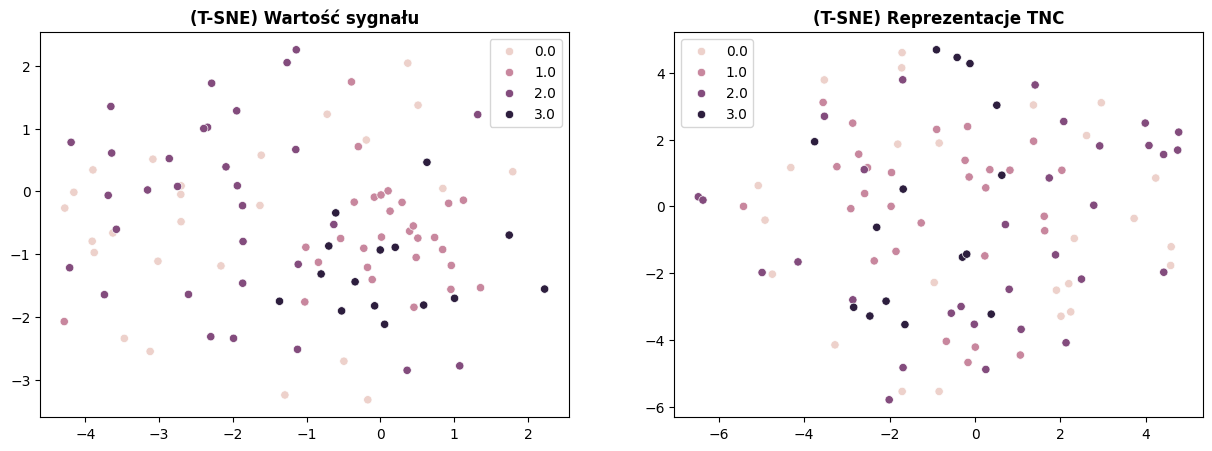

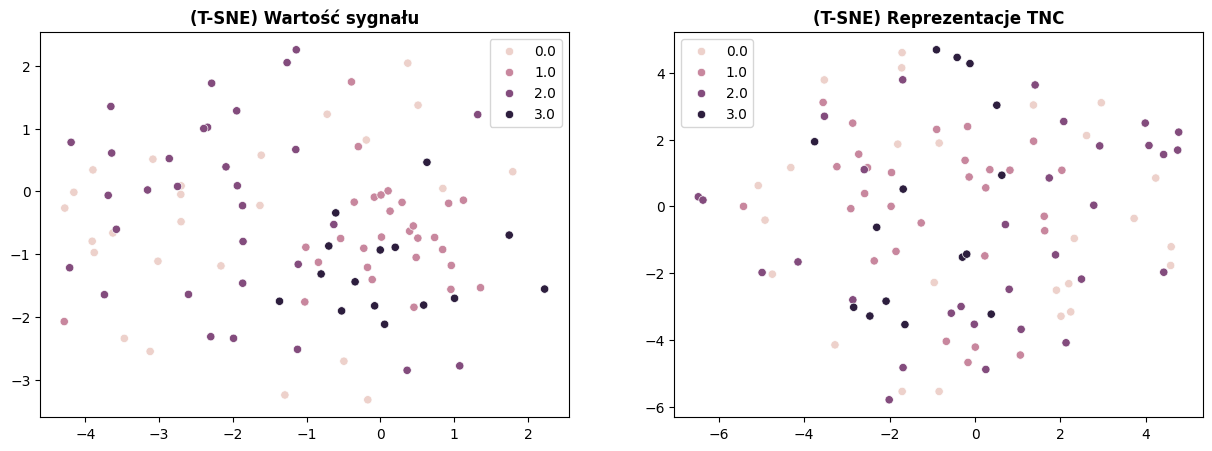

In [78]:
from src.utils import visualize_embeddings
from src.evaluations import evaluate_model


def visualize(name: str):
    best_tnc_model = TNCModel.load_from_checkpoint(
        checkpoint_path=f"./data/checkpoints/{name}/model.ckpt"
    )

    best_encoder = best_tnc_model.encoder

    dataset = torch.load("./data/simulated.pt")

    fig = visualize_embeddings(
        x_all=dataset["x_all"],
        y_all=dataset["y_all"],
        encoder=best_encoder,
        window_size=best_tnc_model.hparams["window_size"],
    )
    return fig


visualize(default_hparams["name"])

In [79]:
def evaluate_classification_clustering(name: str):
    best_tnc_model = TNCModel.load_from_checkpoint(
        checkpoint_path=f"./data/checkpoints/{name}/model.ckpt"
    )

    best_encoder = best_tnc_model.encoder

    dataset = torch.load("./data/simulated.pt")

    metrics = evaluate_model(
        dataset=dataset,
        encoder=best_encoder,
        window_size=best_tnc_model.hparams["window_size"],
    )

    return metrics


evaluate_classification_clustering(default_hparams["name"])

{'auc': {'train': 0.8382927129319171,
  'val': 0.8179088677087454,
  'test': 0.8358874593829715},
 'cluster': {'silhouette': 0.16255681, 'davies_bouldin': 1.682417380777769}}

## Zadanie 2.5. Badanie wpływu metody agregacji oraz dyskryminatora TNC (1.5 pkt)

Korzystając z domyślnych hiperparametrów sprawdź, który z zaimplementowanych modułów agregacji oraz dyskryminatora dostarcza najlepszych rezultatów. Sprawdź wszystkie 4 kombinacje $\{\mathrm{last}, \mathrm{attn}\} \times \{\mathrm{dot}, \mathrm{mlp}\}$


In [116]:
import pprint

pprint.pprint(default_hparams)

{'agg': 'last',
 'batch_size': 10,
 'discriminator': 'dot',
 'emb_dim': 10,
 'hidden_dim': 100,
 'in_dim': 3,
 'lr': 0.001,
 'mc_sample_size': 40,
 'name': 'default',
 'num_epochs': 50,
 'w': 0.05,
 'weight_decay': 0.001,
 'window_size': 50}


In [ ]:
# TU WPISZ KOD


def get_params(
    agg: Literal["last", "attn"] = "last",
    discriminator: Literal["dot", "mlp"] = "dot",
    name: str = "default",
    window_size: int = 50,
    w: float = 0.05,
):
    return {
        "agg": agg,
        "discriminator": discriminator,
        "in_dim": 3,
        "hidden_dim": 100,
        "emb_dim": 10,
        "window_size": window_size,
        "mc_sample_size": 40,
        "w": w,
        "num_epochs": 50,
        "lr": 1e-3,
        "weight_decay": 1e-3,
        "batch_size": 10,
        "name": name,
    }


last_dot_params = get_params("last", "dot", "last_dot")
last_mlp_params = get_params("last", "mlp", "last_mlp")
attn_dot_params = get_params("attn", "dot", "attn_dot")
attn_mlp_params = get_params("attn", "mlp", "attn_mlp")

In [ ]:
train(hparams=last_dot_params)

In [112]:
train(hparams=last_mlp_params)

In [113]:
train(hparams=attn_dot_params)

In [ ]:
train(hparams=attn_mlp_params)

In [115]:
import pandas as pd

names = [
    "last_dot",
    "last_mlp",
    "attn_dot",
    "attn_mlp",
]


def disp_res(name: str):
    res = evaluate_classification_clustering(name)
    res_auc = pd.DataFrame(res["auc"], index=["auc"])
    res_cluster = pd.DataFrame(res["cluster"], index=["cluster"])
    print(name)
    display(res_auc)
    display(res_cluster)


for name in names:
    disp_res(name)

last_dot


,train,val,test
auc,0.838293,0.817909,0.835887


,silhouette,davies_bouldin
cluster,0.162631,1.682829


last_mlp


,train,val,test
auc,0.777599,0.76578,0.795628


,silhouette,davies_bouldin
cluster,0.445236,0.6757


attn_dot


,train,val,test
auc,0.899795,0.869061,0.904298


,silhouette,davies_bouldin
cluster,0.433516,0.82165


attn_mlp


,train,val,test
auc,0.840411,0.812395,0.862501


,silhouette,davies_bouldin
cluster,0.508303,0.618764


In [117]:
print(evaluate_classification_clustering("last_dot"))

{'auc': {'train': 0.8382927129319171, 'val': 0.8179088677087454, 'test': 0.8358874593829715}, 'cluster': {'silhouette': 0.16284761, 'davies_bouldin': 1.6788753905684892}}


## Zadanie 2.6. Badanie hiperparametrów metody TNC (1.5 pkt)

Korzystając z podanych funkcji `train()` oraz `evaluate_classification_clustering()` zbadaj następujące hiperparametry:

- `window_size` (zbadaj co najmniej 3 wartości)
- `w` (zbadaj co najmniej 3 wartości)

Jeśli uczenie modelu będzie zbyt czasochłonne można zredukować liczbę epok. Każdy z parametrów można zbadać osobno - nie ma potrzeby przeglądania ich przekroju. Analizy powinny być prowadzone na podstawie metryk: AUC (zbiór testowy) oraz metryki klasteryzacji (Silhouette oraz Davies-Bouldin). Utwórz tabelki, które podsumują wyniki eksperymentów. Skomentuj wyniki


In [ ]:
# TU WPISZ KOD
window_sizes = [10, 50, 100]
w_values = [0.05, 0.5, 0.95]


for window_size in window_sizes:
    w = 0.05
    name = f"window_{window_size}_w_{w}"
    params = get_params(window_size=window_size, w=w, name=name)
    train(hparams=params)

In [ ]:
for w in w_values:
    window_size = 50
    name = f"window_{window_size}_w_{w}"
    params = get_params(window_size=window_size, w=w, name=name)
    train(hparams=params)

In [ ]:
# display results
for window_size in window_sizes:
    w = 0.05
    name = f"window_{window_size}_w_{w}"
    disp_res(name)

for w in w_values:
    window_size = 50
    name = f"window_{window_size}_w_{w}"
    disp_res(name)

In [122]:
import matplotlib.pyplot as plt

window_sizes = [10, 50, 100]
w_values = [0.05, 0.5, 0.95]


def collect_results(window_sizes, w_values):
    results = []

    for window_size in window_sizes:
        w = 0.05
        name = f"window_{window_size}_w_{w}"
        result = evaluate_classification_clustering(name)
        result["name"] = name
        result["window_size"] = window_size
        result["w"] = w
        results.append(result)

    # for w in w_values:
    #     window_size = 50
    #     name = f"window_{window_size}_w_{w}"
    #     result = evaluate_classification_clustering(name)
    #     result["name"] = name
    #     result["window_size"] = window_size
    #     result["w"] = w
    #     results.append(result)

    return results


results = collect_results(window_sizes, w_values)

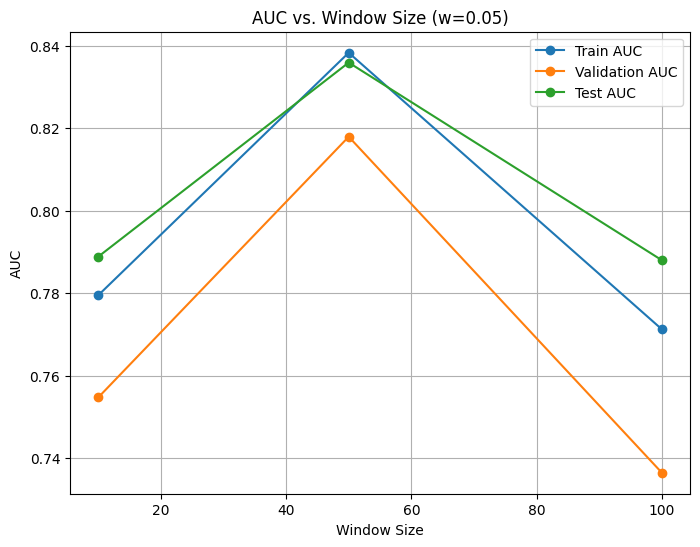

In [123]:
window_size_results = [r for r in results if r["w"] == 0.05]
window_size_x = [r["window_size"] for r in window_size_results]
auc_train_ws = [r["auc"]["train"] for r in window_size_results]
auc_val_ws = [r["auc"]["val"] for r in window_size_results]
auc_test_ws = [r["auc"]["test"] for r in window_size_results]

plt.figure(figsize=(8, 6))
plt.plot(window_size_x, auc_train_ws, label="Train AUC", marker="o")
plt.plot(window_size_x, auc_val_ws, label="Validation AUC", marker="o")
plt.plot(window_size_x, auc_test_ws, label="Test AUC", marker="o")
plt.xlabel("Window Size")
plt.ylabel("AUC")
plt.title("AUC vs. Window Size (w=0.05)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Extract relevant metrics for w values
w_value_results = [r for r in results if r["window_size"] == 50]
w_value_x = [r["w"] for r in w_value_results]
auc_train_w = [r["auc"]["train"] for r in w_value_results]
auc_val_w = [r["auc"]["val"] for r in w_value_results]
auc_test_w = [r["auc"]["test"] for r in w_value_results]

# Plot for w values
plt.figure(figsize=(8, 6))
plt.plot(w_value_x, auc_train_w, label="Train AUC", marker="o")
plt.plot(w_value_x, auc_val_w, label="Validation AUC", marker="o")
plt.plot(w_value_x, auc_test_w, label="Test AUC", marker="o")
plt.xlabel("w")
plt.ylabel("AUC")
plt.title("AUC vs. w (Window Size=50)")
plt.legend()
plt.grid(True)
plt.show()